# Garbage Image Classification with TensorFlow and TFLite Conversion

This notebook demonstrates how to build an image classification model for garbage data and convert it to TFLite format for mobile deployment.

## Import Required Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import random
from sklearn.metrics import classification_report, confusion_matrix
import cv2
from pathlib import Path

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU'))>0}")

TensorFlow version: 2.10.0
Keras version: 2.10.0
GPU Available: False


## Load and Explore the Dataset

The dataset contains images of different types of garbage categorized into various classes:
- battery
- biological
- brown-glass
- cardboard
- clothes
- green-glass
- metal
- paper
- plastic
- shoes
- trash
- white-glass

Found 12 classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
battery: 945 images
biological: 985 images
brown-glass: 607 images
cardboard: 891 images
clothes: 5325 images
green-glass: 629 images
metal: 769 images
paper: 1050 images
plastic: 865 images
shoes: 1977 images
trash: 697 images
white-glass: 775 images


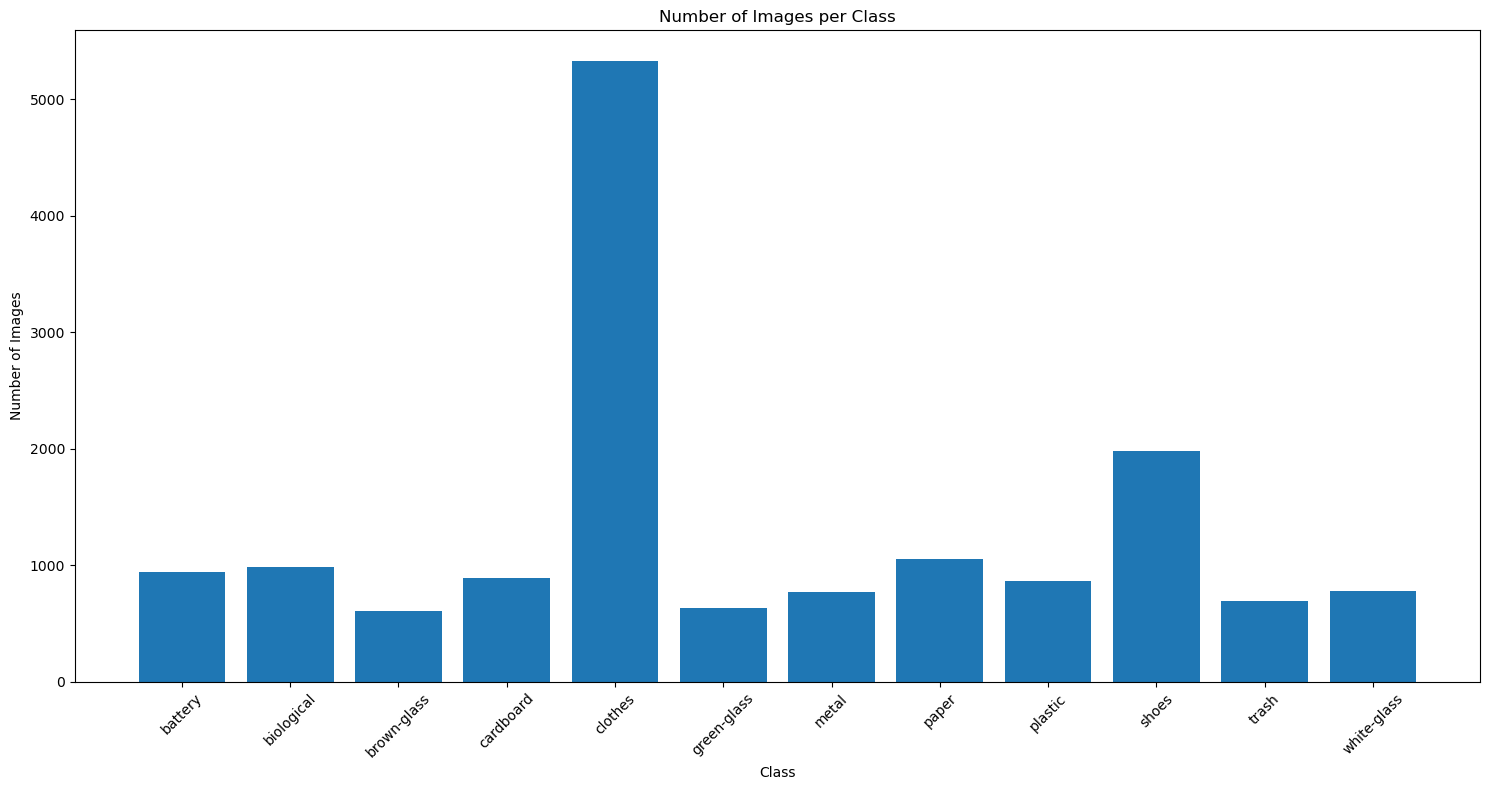

In [3]:
# Define the data directory
DATA_DIR = r"c:\Users\ASUS\Desktop\VHack Training\Garbage Images\garbage_classification"

# List all classes (subdirectories)
classes = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
print(f"Found {len(classes)} classes: {classes}")

# Count the number of images in each class
class_counts = {}
for cls in classes:
    class_path = os.path.join(DATA_DIR, cls)
    count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    class_counts[cls] = count
    
# Display class distribution
for cls, count in class_counts.items():
    print(f"{cls}: {count} images")

# Visualize class distribution
plt.figure(figsize=(15, 8))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Display Sample Images from Each Class

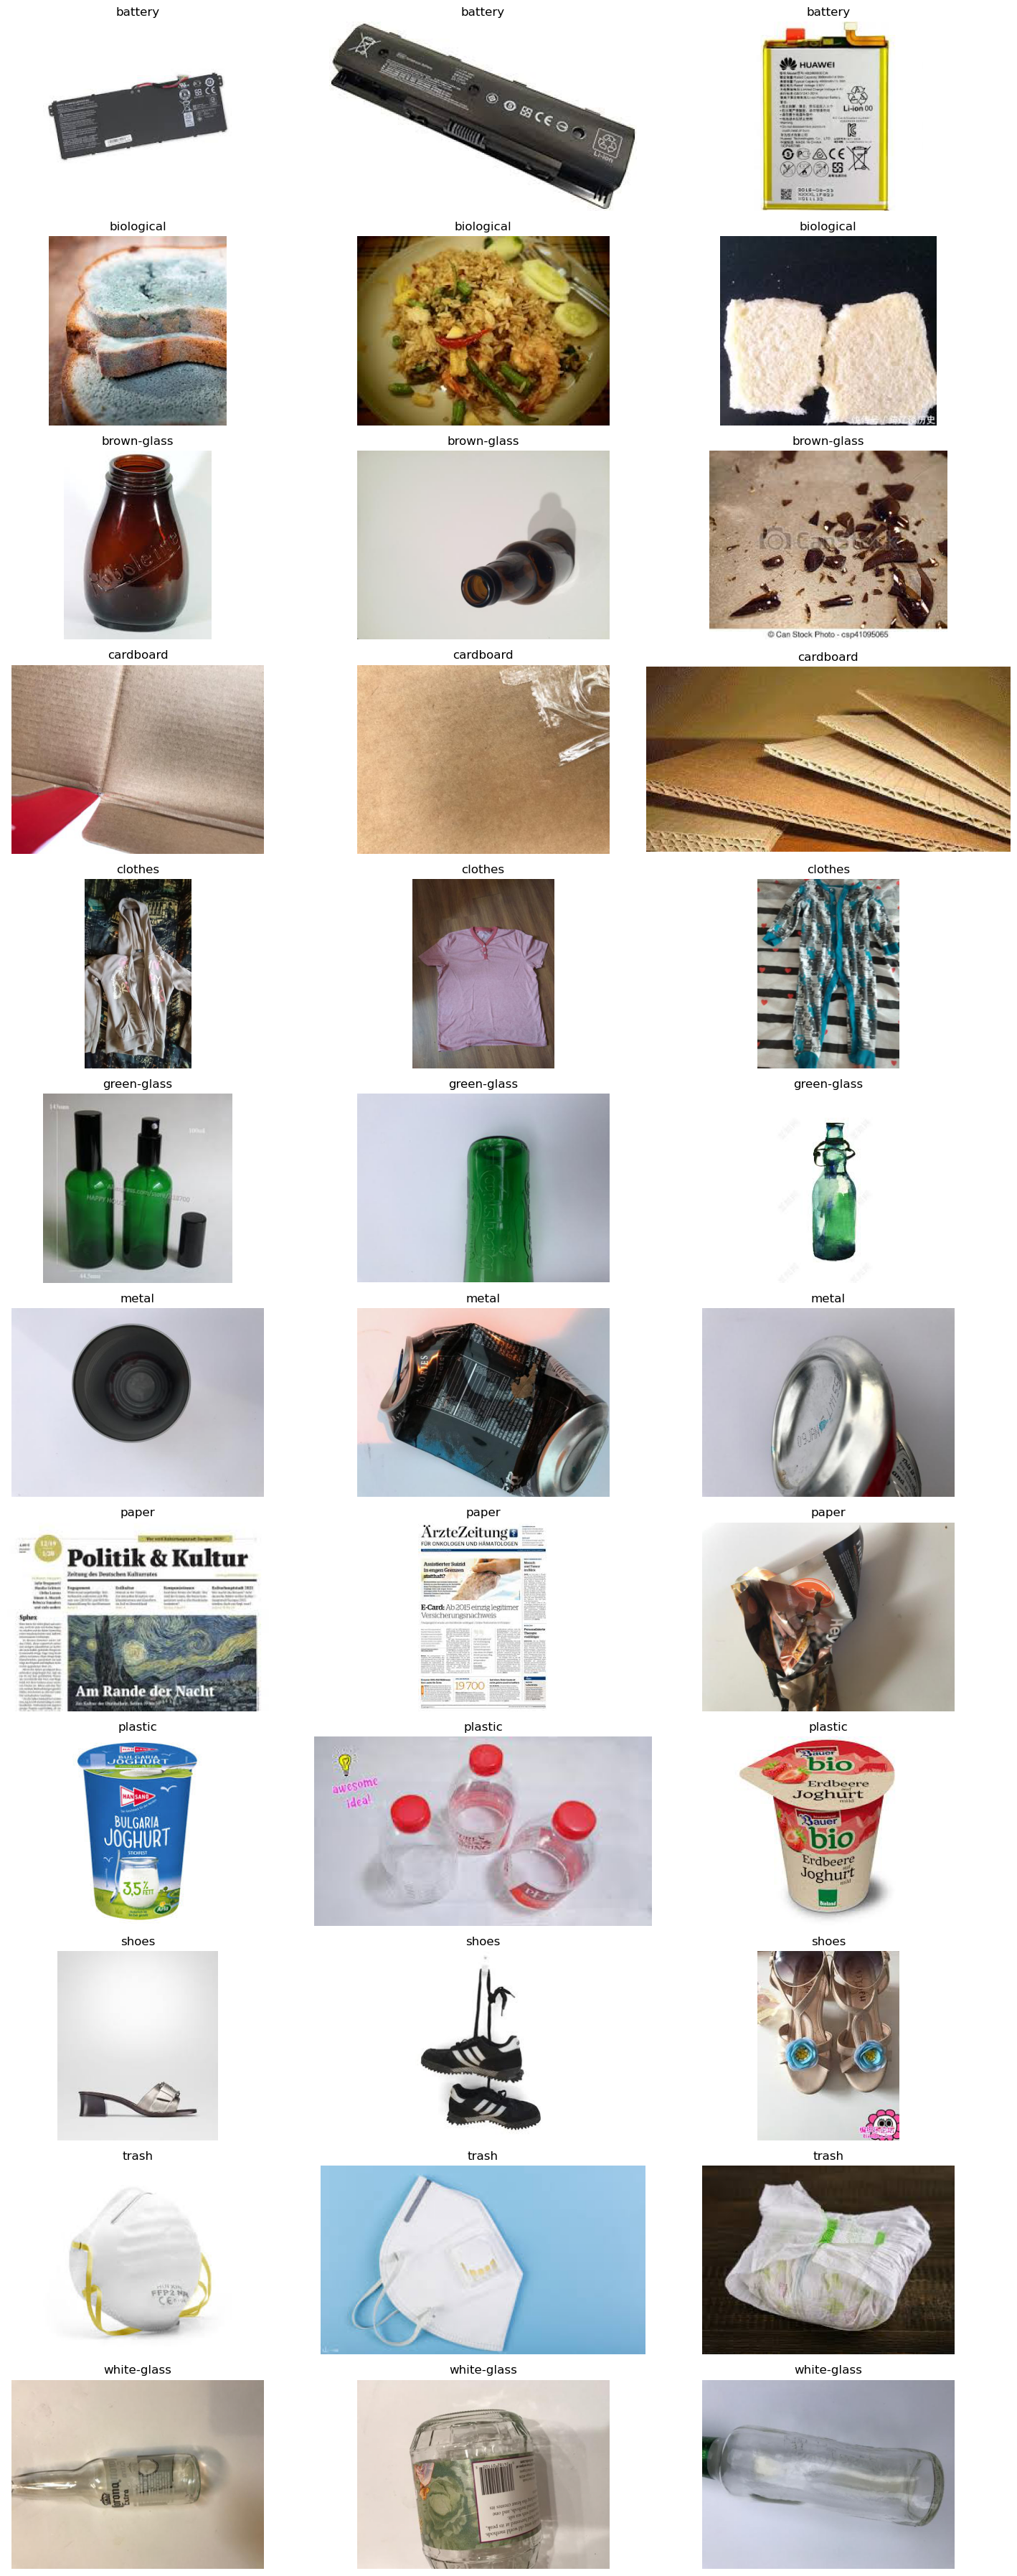

In [13]:
# Function to display sample images
def display_sample_images(classes, num_samples=3):
    plt.figure(figsize=(15, len(classes)*3))
    for i, cls in enumerate(classes):
        class_path = os.path.join(DATA_DIR, cls)
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        samples = random.sample(images, min(num_samples, len(images)))
        
        for j, img_name in enumerate(samples):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            
            plt.subplot(len(classes), num_samples, i*num_samples + j + 1)
            plt.imshow(img)
            plt.title(f"{cls}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display sample images
display_sample_images(classes)

## Preprocess the Images

We'll resize all images to a fixed size and normalize the pixel values.

In [14]:
# Define image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Create data generators with data augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% for validation
)

# Test data generator (no augmentation)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.1  # 10% for testing from the validation set
)

## Create Data Generators

We'll use Keras' ImageDataGenerator to load and preprocess our images in batches.

In [15]:
# Create train generator
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Create validation generator
validation_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Create test generator from validation set
test_generator = test_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Get class indices for mapping predictions to class names
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
print("Class indices:", class_indices)

Found 12415 images belonging to 12 classes.
Found 3100 images belonging to 12 classes.
Found 1545 images belonging to 12 classes.
Class indices: {'battery': 0, 'biological': 1, 'brown-glass': 2, 'cardboard': 3, 'clothes': 4, 'green-glass': 5, 'metal': 6, 'paper': 7, 'plastic': 8, 'shoes': 9, 'trash': 10, 'white-glass': 11}


## Build a CNN Model

We'll use transfer learning with MobileNetV2 as our base model since it's efficient and well-suited for mobile deployment.

In [16]:
# Create a function to build the model
def build_model(num_classes):
    # Load the pre-trained MobileNetV2 model
    base_model = MobileNetV2(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze the base model layers
    base_model.trainable = False
    
    # Create the model with the custom top layers
    model = Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Build the model
num_classes = len(class_names)
model = build_model(num_classes)

# Summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 12)                1548      
                                                                 
Total params: 2,423,500
Trainable params: 165,516
Non-

## Train the Model

We'll compile and train the model with appropriate callbacks for better training.

In [17]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Set up callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
388/388 [==============================] - 648s 2s/step - loss: 0.6169 - accuracy: 0.8130 - val_loss: 0.3864 - val_accuracy: 0.8729 - lr: 0.0010
Epoch 2/20
388/388 [==============================] - 417s 1s/step - loss: 0.3292 - accuracy: 0.8960 - val_loss: 0.3133 - val_accuracy: 0.8965 - lr: 0.0010
Epoch 3/20
388/388 [==============================] - 435s 1s/step - loss: 0.2964 - accuracy: 0.9080 - val_loss: 0.3176 - val_accuracy: 0.8923 - lr: 0.0010
Epoch 4/20
388/388 [==============================] - 427s 1s/step - loss: 0.2722 - accuracy: 0.9149 - val_loss: 0.2920 - val_accuracy: 0.9029 - lr: 0.0010
Epoch 5/20
388/388 [==============================] - 457s 1s/step - loss: 0.2434 - accuracy: 0.9197 - val_loss: 0.2924 - val_accuracy: 0.9003 - lr: 0.0010
Epoch 6/20
388/388 [==============================] - 435s 1s/step - loss: 0.2415 - accuracy: 0.9223 - val_loss: 0.2911 - val_accuracy: 0.9023 - lr: 0.0010
Epoch 7/20
388/388 [==============================] - 447s 1s/st

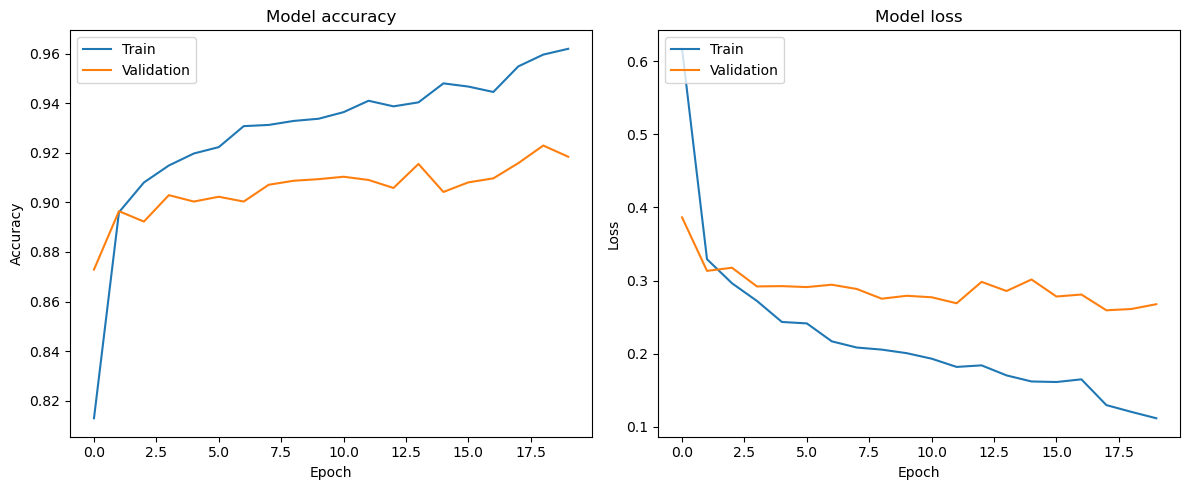

Epoch 1/10
388/388 [==============================] - 435s 1s/step - loss: 0.2485 - accuracy: 0.9262 - val_loss: 0.4457 - val_accuracy: 0.9003 - lr: 1.0000e-04
Epoch 2/10
388/388 [==============================] - 2768s 7s/step - loss: 0.1896 - accuracy: 0.9376 - val_loss: 0.4055 - val_accuracy: 0.9000 - lr: 1.0000e-04
Epoch 3/10
388/388 [==============================] - 635s 2s/step - loss: 0.1621 - accuracy: 0.9458 - val_loss: 0.3218 - val_accuracy: 0.9152 - lr: 1.0000e-04
Epoch 4/10
388/388 [==============================] - 984s 3s/step - loss: 0.1338 - accuracy: 0.9576 - val_loss: 0.3237 - val_accuracy: 0.9181 - lr: 1.0000e-04
Epoch 5/10
388/388 [==============================] - 974s 3s/step - loss: 0.1189 - accuracy: 0.9611 - val_loss: 0.2863 - val_accuracy: 0.9229 - lr: 1.0000e-04
Epoch 6/10
388/388 [==============================] - 4327s 11s/step - loss: 0.1106 - accuracy: 0.9641 - val_loss: 0.2860 - val_accuracy: 0.9219 - lr: 1.0000e-04
Epoch 7/10
388/388 [=================

In [18]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Fine-tune the model by unfreezing some layers
base_model = model.layers[0]
base_model.trainable = True

# Freeze all layers except for the last 20
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Re-compile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the fine-tuned model for a few more epochs
history_fine = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Save the trained model
model.save('garbage_classification_model.h5')
print("Model saved successfully!")

## Evaluate the Model Performance

Let's evaluate the model on our test dataset and visualize the results.

49/49 [==============================] - 37s 759ms/step - loss: 0.2598 - accuracy: 0.9398
Test Accuracy: 0.9398
Test Loss: 0.2598
49/49 [==============================] - 1358s 28s/step
Classification Report:
              precision    recall  f1-score   support

     battery       1.00      0.83      0.91        94
  biological       0.94      0.97      0.95        98
 brown-glass       0.92      0.97      0.94        60
   cardboard       0.92      0.96      0.94        89
     clothes       0.99      0.99      0.99       532
 green-glass       1.00      0.89      0.94        62
       metal       0.73      0.86      0.79        76
       paper       0.96      0.88      0.92       105
     plastic       0.78      0.93      0.85        86
       shoes       0.97      0.96      0.96       197
       trash       0.89      0.99      0.94        69
 white-glass       0.92      0.77      0.84        77

    accuracy                           0.94      1545
   macro avg       0.92      0.91

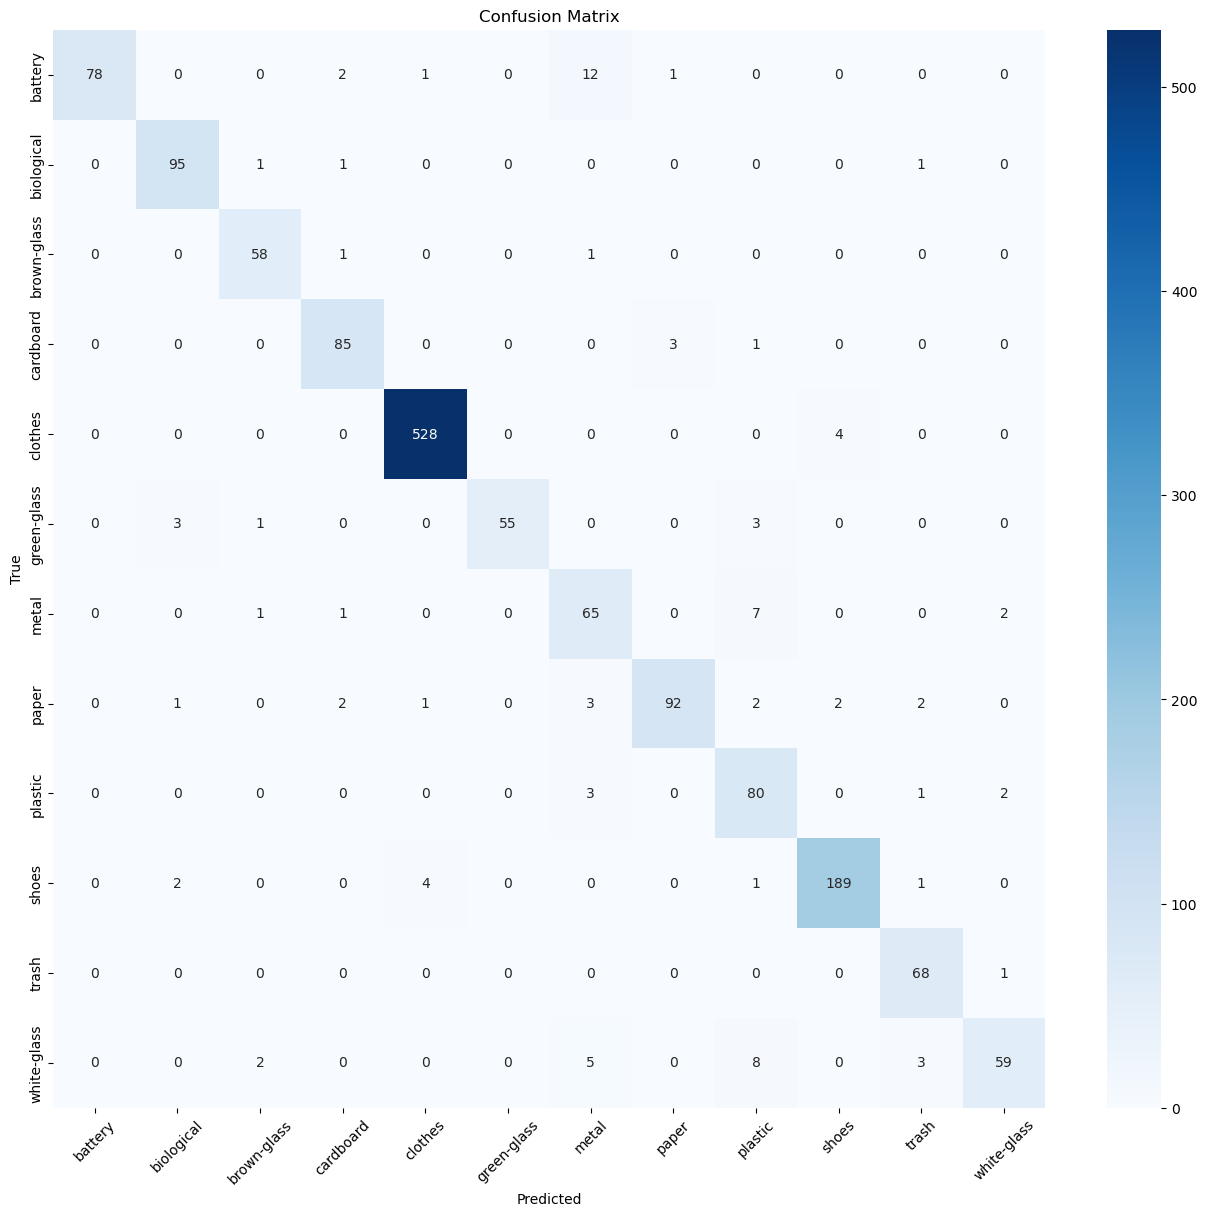

In [19]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Get predictions
test_generator.reset()
y_pred_proba = model.predict(test_generator)
y_pred = np.argmax(y_pred_proba, axis=1)

# Get true labels
y_true = test_generator.classes[:len(y_pred)]

# Create classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

# Create confusion matrix
plt.figure(figsize=(16, 14))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.show()

### Visualize Sample Predictions

1/1 [==============================] - 4s 4s/step


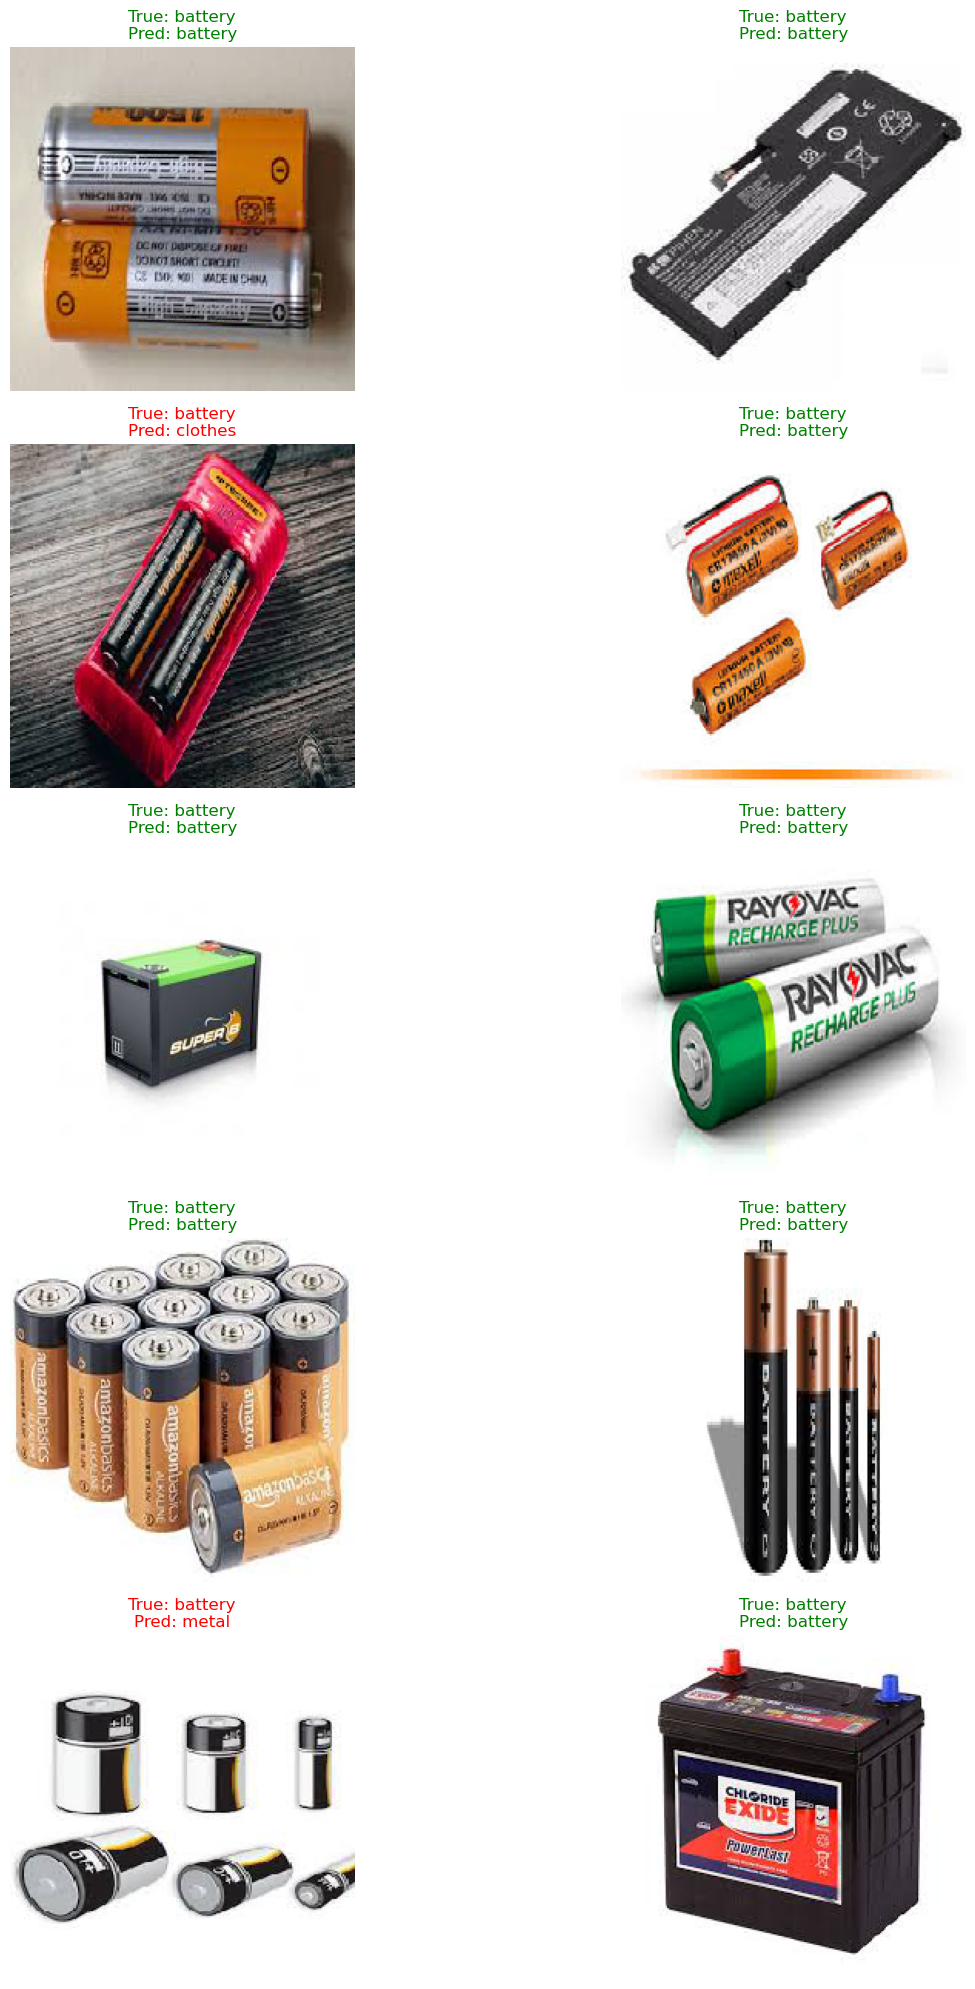

In [20]:
# Function to visualize predictions
def visualize_predictions(generator, model, class_names, num_samples=10):
    generator.reset()
    
    # Get a batch of images and their true labels
    batch_images, batch_labels = next(generator)
    
    # Make predictions
    predictions = model.predict(batch_images)
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(batch_labels, axis=1)
    
    # Display images with predictions
    plt.figure(figsize=(15, 20))
    for i in range(min(num_samples, len(batch_images))):
        plt.subplot(5, 2, i + 1)
        plt.imshow(batch_images[i] * 0.5 + 0.5)  # Denormalize
        
        correct = true_classes[i] == pred_classes[i]
        color = 'green' if correct else 'red'
        
        plt.title(f"True: {class_names[true_classes[i]]}\nPred: {class_names[pred_classes[i]]}", 
                  color=color)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

# Visualize some predictions
visualize_predictions(test_generator, model, class_names)

## Convert to TFLite Format

Now let's convert our trained model to TFLite format for mobile deployment.

In [21]:
# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('garbage_classification_model.tflite', 'wb') as f:
    f.write(tflite_model)
    
print("TFLite model saved successfully!")

# Try quantized model for smaller size
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Set optimization options
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
quantized_tflite_model = converter.convert()

# Save the quantized model
with open('garbage_classification_quantized_model.tflite', 'wb') as f:
    f.write(quantized_tflite_model)
    
print("Quantized TFLite model saved successfully!")

# Compare model sizes
def get_file_size(file_path):
    size_bytes = os.path.getsize(file_path)
    size_mb = size_bytes / (1024 * 1024)
    return size_mb

h5_size = get_file_size('garbage_classification_model.h5')
tflite_size = get_file_size('garbage_classification_model.tflite')
quant_size = get_file_size('garbage_classification_quantized_model.tflite')

print(f"Original H5 model size: {h5_size:.2f} MB")
print(f"TFLite model size: {tflite_size:.2f} MB")
print(f"Quantized TFLite model size: {quant_size:.2f} MB")
print(f"Size reduction (H5 to Quantized): {100 - (quant_size/h5_size*100):.2f}%")

INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpkinmxtkg\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpkinmxtkg\assets


TFLite model saved successfully!


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpy92d_eqw\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpy92d_eqw\assets


Quantized TFLite model saved successfully!
Original H5 model size: 20.06 MB
TFLite model size: 9.09 MB
Quantized TFLite model size: 2.55 MB
Size reduction (H5 to Quantized): 87.28%
